## Imports

In [1]:
import os
import time
import requests
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import math
import datetime


from pandas.plotting import lag_plot
from pandas import datetime
from statsmodels.tsa.arima_model import ARIMA
from pylab import rcParams
from statsmodels.tsa.seasonal import seasonal_decompose
from pandas import DataFrame
from pandas import concat
from sklearn.metrics import mean_squared_error
from datetime import datetime
from math import sqrt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from pmdarima.arima import auto_arima

In [2]:
ls

 Volume in drive D is DATA
 Volume Serial Number is 6AE9-63CD

 Directory of D:\Bhavishya\Documents\Books\Sem5 Books\ML Lab

13-12-2020  18:09    <DIR>          .
13-12-2020  18:09    <DIR>          ..
13-12-2020  18:01    <DIR>          .ipynb_checkpoints
14-09-2020  19:49    <DIR>          .vscode
27-10-2020  12:05           138,595 2113.ipynb
13-12-2020  18:05    <DIR>          archive
11-12-2020  10:33       515,591,518 archive.zip
13-12-2020  02:28            68,617 ARIMA ARCH(b).png
17-10-2020  16:58            32,780 ARIMA ARCH.png
14-09-2020  20:23             3,849 ass1.ipynb
16-09-2020  19:52           138,595 ass1_2.ipynb
17-10-2020  14:44            20,633 Blank diagram.png
17-10-2020  16:49            19,611 Blank diagram1.png
02-11-2020  10:43            58,140 CarDatabase.xlsx
04-11-2020  19:32            19,579 Decision Tree and Naive Bayes.ipynb
15-09-2020  11:21             1,423 l02_slp_flower.py
16-09-2020  21:00            40,162 Lab3_GD.ipynb
12-12-2020  23:15    

## Data input

In [3]:
os.chdir('archive/')

In [4]:
etf_legend = pd.read_csv('etf_legend.csv')
stock_legend = pd.read_csv('stock_legend.csv')

In [5]:
os.chdir('Stocks/')

In [6]:
stock_data = {}
pd.options.mode.use_inf_as_na = True
dateparse = lambda dates: datetime.strptime(dates, '%Y-%m-%d')
for i in stock_legend.Sym:
    if os.path.isfile(i) and os.path.getsize(i) > 0:
        stock_data[i] = pd.read_csv(i, sep=',', header=0).fillna(0)
        stock_data[i] = pd.read_csv(i, sep=',', parse_dates=['Date'], index_col='Date',date_parser=dateparse)
        stock_data[i].fillna(method='ffill')
    else:
        etf_legend.drop(etf_legend.loc[etf_legend.Sym==i].index, inplace=True)

In [7]:
len(stock_data)

45

In [8]:
os.chdir('../ETFs')

In [9]:
etf_data = {}
pd.options.mode.use_inf_as_na = True
dateparse = lambda dates: datetime.strptime(dates, '%Y-%m-%d')
for i in etf_legend.Sym:
    if os.path.isfile(i) and os.path.getsize(i) > 0:
        etf_data[i] = pd.read_csv(i, sep=',', header=0).fillna(0)
        etf_data[i] = pd.read_csv(i, sep=',', parse_dates=['Date'], index_col='Date',date_parser=dateparse)
        etf_data[i].fillna(method='ffill')
    else:
        etf_legend.drop(etf_legend.loc[etf_legend.Sym==i].index, inplace=True)

In [10]:
len(etf_data)

45

## ARIMA

##### Function to plot close price of given data

In [11]:
C = 0
def plotclose(data):
    global C
    C = C+1
    close_price = pd.DataFrame()
    for i in data.keys():
        close_price[i]=data[i]['Close']
    close_price = close_price.fillna(method='ffill')
    close_price.index =close_price.index.astype('datetime64[ns]')
    close_price=close_price.dropna(inplace = False)
    %matplotlib inline
    _ = pd.concat([close_price],axis=1).plot(figsize=(30,20),grid=True, xlabel='Time', ylabel='Close Price')
    txt = 'plotclose('+str(C)+').png'
    plt.savefig(txt)

##### Function to plot seasonal of given data

In [12]:
def seasonal_decomposition(data, name):
    rcParams['figure.figsize'] = 16, 8
    result = seasonal_decompose(data.Close, model='multiplicative', freq=30)
    plt.figure(figsize=(16,8))
    fig = result.plot()
    txt = 'seas_decomp('+name+').png'
    plt.savefig(txt)
    plt.show()
    

##### Function to test stationarity using adfuller test of given data

In [13]:
def test_stationarity(timeseries, name, choice, window = 12, cutoff = 0.01):

    #Determing rolling statistics
    rolmean = timeseries.rolling(window).mean()
    rolstd = timeseries.rolling(window).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    tit = name+' | '+choice
    plt.title(tit)
    txt = 'stationarity('+name+choice+').png'
    if not os.path.isfile(txt):
        plt.savefig(txt)
    plt.show()
    
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC', maxlag = 20 )
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    pvalue = dftest[1]
    if pvalue < cutoff:
        print('p-value = %.4f. The series is likely stationary.' % pvalue)
    else:
        print('p-value = %.4f. The series is likely non-stationary.' % pvalue)
    
    print(dfoutput)

##### Function to plot pacf and acf

In [14]:
def plot_correlation(data, name):
    lag_acf = acf(np.log(data.Close), nlags=1000)
    lag_pacf = pacf(np.log(data.Close), nlags=5)

    #Plot ACF:
    plt.subplot(121)
    plt.plot(lag_acf)
    plt.axhline(y=0, linestyle='--', color='gray')
    plt.axhline(y=-1.96/np.sqrt(len(data)), linestyle='--', color='gray')
    plt.axhline(y=1.96/np.sqrt(len(data)), linestyle='--', color='gray')
    tit = name+' | Autocorrelation Function'
    plt.title(tit)            

    #Plot PACF
    plt.subplot(122)
    plt.plot(lag_pacf)
    plt.axhline(y=0, linestyle='--', color='gray')
    plt.axhline(y=-1.96/np.sqrt(len(data)), linestyle='--', color='gray')
    plt.axhline(y=1.96/np.sqrt(len(data)), linestyle='--', color='gray')
    tit = name+' | Partial Autocorrelation Function'
    plt.title(tit)

    plt.tight_layout() 
    txt = 'corr_plot('+name+').png'
    if not os.path.isfile(txt):
        plt.savefig(txt)

##### Function to plot different tranforms

In [15]:
def transformers(data, ch, name):
    indexedDataset_logScale = np.log(data.Close)
    movingAverage = indexedDataset_logScale.rolling(window=12).mean()
    movingSTD = indexedDataset_logScale.rolling(window=12).std()
    datasetLogScaleMinusMovingAverage = indexedDataset_logScale - movingAverage
    datasetLogScaleMinusMovingAverage.dropna(inplace=True)
    exponentialDecayWeightedAverage = indexedDataset_logScale.ewm(halflife=12, min_periods=0, adjust=True).mean()
    datasetLogScaleMinusExponentialMovingAverage = indexedDataset_logScale - exponentialDecayWeightedAverage
    first_diff = data.Close - data.Close.shift(1)
    first_diff = first_diff.dropna(inplace = False)
    datasetLogDiffShifting = indexedDataset_logScale - indexedDataset_logScale.shift()
    datasetLogDiffShifting.dropna(inplace=True)
    if ch == 1:
        choice = 'Log Scale'
        test_stationarity(indexedDataset_logScale,name,choice)
    elif ch == 2:
        choice = 'Log Minus Moving Average'
        test_stationarity(datasetLogScaleMinusMovingAverage,name,choice)
    elif ch == 3:
        choice = 'Log Minus Exponential Moving Average'
        test_stationarity(datasetLogScaleMinusExponentialMovingAverage,name,choice)
    elif ch == 4:
        choice = 'First Difference'
        test_stationarity(first_diff,name,choice)
    elif ch == 5:
        choice = 'First Log Difference'
        test_stationarity(datasetLogDiffShifting,name,choice)
    else:
        print('Invalid input\n1: Log Scale\n2: Log Minus Moving Average\n3: Log Minus Exponential Moving Average\n4: First Difference\n5: First Log Difference')

##### Function to split given data

In [16]:
def splitter(data):
    train_data, val_data, test_data = data[0:int(len(data)*0.8)], data[int(len(data)*0.8):int(len(data)*0.9)], data[int(len(data)*0.9):]
    lit_test = data[int(len(data)*0.8):]
    return (train_data, val_data, test_data, lit_test)

##### Function to plot initial input

In [17]:
def in_plot(data, test_data, val_data, lit_test, predictions,name):
    tit = name+' Stock Price Prediction'
    plt.figure(figsize=(16,8))
    plt.plot(data.index, data['Close'], color='green', label = 'Train Stock Price')
    plt.plot(lit_test.index, lit_test.Close, color = 'blue', label = 'Real Stock Price')
    plt.plot(val_data.index, val_data['Close'], 'orange', label='Val Stock Price')
    plt.title(tit)
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    txt = 'initial('+name+').png'
    plt.savefig(txt)
    plt.show()
    
    

    plt.figure(figsize=(14,8))
    plt.plot(data.index[-int(.2*len(data)):], data['Open'].tail(int(.2*len(data))),color='green', label = 'Train Stock Price')
    plt.plot(lit_test.index, lit_test.Close, color = 'blue', label = 'Real Stock Price')
    plt.plot(val_data.index, val_data['Close'], 'orange', label='Val Stock Price')
    plt.title(tit)
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    txt = 'initial_tail('+name+').png'
    plt.savefig(txt)
    plt.show()
    

##### Function to plot final output

In [18]:
def fin_plot(data, test_data, val_data, lit_test, predictions,name):
    tit = name+' Stock Price Prediction'
    plt.figure(figsize=(16,8))
    plt.plot(data.index, data['Close'], color='green', label = 'Train Stock Price')
    plt.plot(lit_test.index, lit_test.Close, color = 'blue', label = 'Real Stock Price')
#     plt.plot(val_data.index, val_data['Close'], 'orange', label='Val Stock Price')
    plt.plot(lit_test.index, predictions, color = 'yellow', label = 'Predicted Stock Price')
    plt.title(tit)
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    txt = 'final('+name+').png'
    plt.savefig(txt)
    plt.show()
    
    

    plt.figure(figsize=(14,8))
    plt.plot(data.index[-int(.2*len(data)):], data['Open'].tail(int(.2*len(data))),color='green', label = 'Train Stock Price')
    plt.plot(lit_test.index, lit_test.Close, color = 'blue', label = 'Real Stock Price')
#     plt.plot(val_data.index, val_data['Close'], 'orange', label='Val Stock Price')
    plt.plot(lit_test.index, predictions, color = 'yellow', label = 'Predicted Stock Price')
    plt.title(tit)
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    txt = 'finaltail('+name+').png'
    plt.savefig(txt)
    plt.show()
    

### Training function using AutoARIMA

In [19]:
def training(data):
    train_data = splitter(data)[0]
    val_data = splitter(data)[1]
    test_data = splitter(data)[2]
    lit_test = splitter(data)[3]
    stepwise_model = auto_arima(train_data.Close, start_p=0, start_q=0, error_action='ignore')
    train_arima = train_data['Close']
    test_arima = lit_test['Close']

    history = [x for x in train_arima]
    y = test_arima
    # make first prediction
    predictions = list()
    stepwise_model.fit(history)
    future_forecast = stepwise_model.predict(n_periods=1)
    yhat = future_forecast[0]
    predictions.append(yhat)
    history.append(y[0])
    # rolling forecasts
    for i in range(1, len(y)):
        stepwise_model.fit(history)
        future_forecast = stepwise_model.predict(n_periods=1)
        yhat = future_forecast[0]
        # invert transformed prediction
        predictions.append(yhat)
        # observation
        obs = y[i]
        history.append(obs)
    # report performance
    mse = mean_squared_error(y, predictions)
#     print('MSE: '+str(mse))
    mae = mean_absolute_error(y, predictions)
#     print('MAE: '+str(mae))
    rmse = math.sqrt(mean_squared_error(y, predictions))
#     print('RMSE: '+str(rmse))
    lit_test.insert(6, "Predictions", predictions, True) 
    return (y, predictions, mse, mae, rmse, lit_test)

##### Training for all the ETFs

In [20]:
os.chdir('..')

In [21]:
os.chdir('Output')

In [22]:
os.chdir('ETFs')

In [23]:
def clean_dataset(df):
    assert isinstance(df, pd.DataFrame), "df needs to be a pd.DataFrame"
    df.dropna(inplace=True)
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(1)
    return df[indices_to_keep].astype(np.float64)

In [24]:
etf_output = {}
etfout = {}
dateparse = lambda dates: datetime.strptime(dates, '%Y%m%d')
for i in etf_data.keys():
    txt = (i.split('.',2)[0]+'.'+i.split('.',2)[1]+'.csv')
    if os.path.isfile(txt):
#         print(txt,'\talready exists')
        etfout[i] = pd.read_csv(txt, sep=',', header=0).fillna(0)
        etfout[i] = pd.read_csv(txt, sep=',', parse_dates=['Date'], index_col='Date',date_parser=dateparse)
        etfout[i].fillna(method='ffill')
    else:
        begin = time.time() 
        etf_output[i] = training(clean_dataset(etf_data[i]))
        end = time.time() 
        print (i,'is done in',(end-begin),'seconds')
        etf_output[i][5].to_csv(txt, encoding='utf-8', date_format='%Y%m%d')
    

##### Training for all the Stocks

In [25]:
os.chdir('..')

In [26]:
os.chdir('Stocks')

In [27]:
stock_output = {}
stockout = {}
dateparse = lambda dates: datetime.strptime(dates, '%Y%m%d')
for i in stock_data.keys():
    txt = (i.split('.',2)[0]+'.'+i.split('.',2)[1]+'.csv')
    if os.path.isfile(txt):
#         print(txt,'\talready exists')
        stockout[i] = pd.read_csv(txt, sep=',', header=0).fillna(0)
        stockout[i] = pd.read_csv(txt, sep=',', parse_dates=['Date'], index_col='Date',date_parser=dateparse)
        stockout[i].fillna(method='ffill')
    else:
        begin = time.time()
        stock_output[i] = training(clean_dataset(stock_data[i]))
        end = time.time() 
        print (i,'is done in',(end-begin),'seconds')
        stock_output[i][5].to_csv(txt, encoding='utf-8', date_format='%Y%m%d')

In [28]:
def get_mape(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [29]:
def get_rmse(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return math.sqrt(mean_squared_error(y_true, y_pred))

## EDA

In [30]:
os.chdir('../results/')

### Plotting Close Price for all 45 Stocks

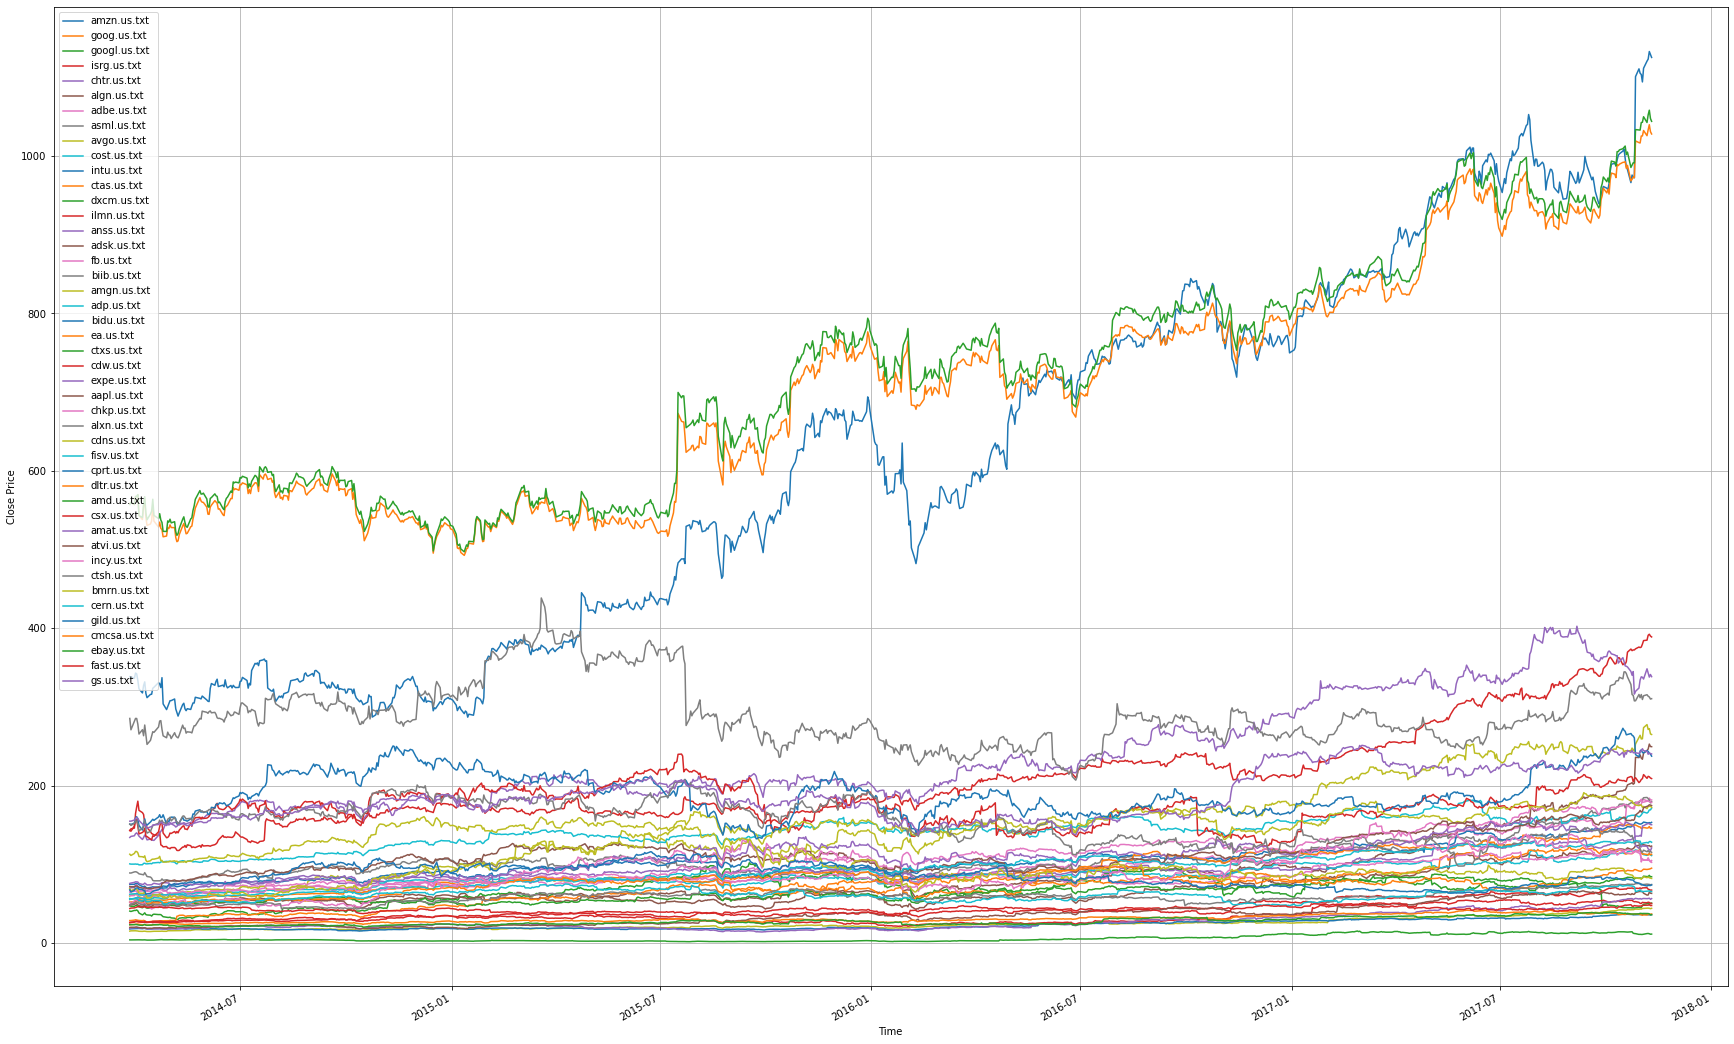

In [31]:
plotclose(stock_data)

### Plotting Close Price for all 45 ETFs

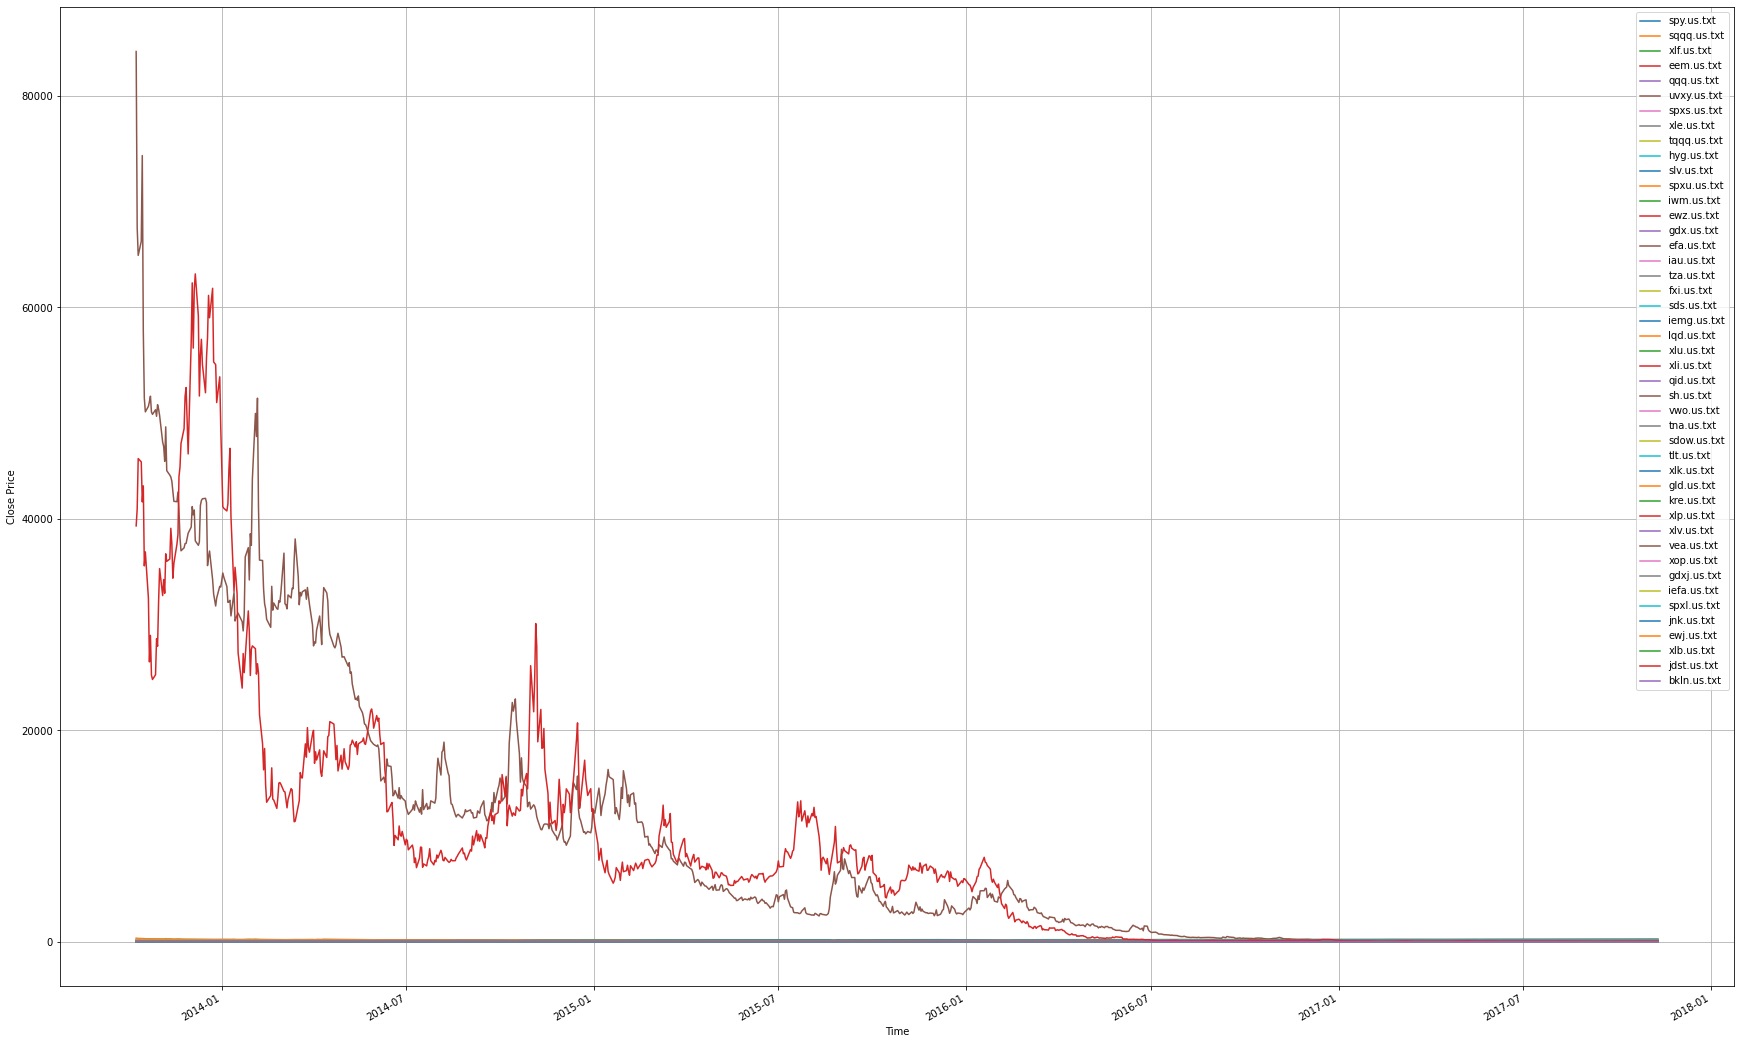

In [32]:
plotclose(etf_data)

#### User Input to select which Stock or RTF to plot

In [33]:
ch = input("Stocks/ETFs(S/E): ")
name =''
if (ch == 's' or ch == 'S'):
    print("--Available Stocks--")
    for i, j in zip(stock_legend.Name, stock_legend.Sym):
        print((j.split('.',1)[0]).upper(),'\t',i)
    val = input("Enter your value: ") 
    val = val.lower()
    val = val+'.us.txt'
    for i, j in zip(stock_legend.Name, stock_legend.Sym):
        if j == val:
            name = i
            break
elif (ch == 'e' or ch == 'E'):
    print("--Available EFTs--")
    for i, j in zip(etf_legend.Name, etf_legend.Sym):
        print((j.split('.',1)[0]).upper(),'\t',i)
    val = input("Enter your value: ") 
    val = val.lower()
    val = val+'.us.txt'
    for i, j in zip(etf_legend.Name, etf_legend.Sym):
        if j == val:
            name = i
            break

Stocks/ETFs(S/E):  e


--Available EFTs--
SPY 	 SPDR S&P 500 ETF
SQQQ 	 ProShares UltraPro Short QQQ
XLF 	 Financial Select Sector SPDR Fund
EEM 	 iShares MSCI Emerging Markets ETF
QQQ 	 Invesco QQQ
UVXY 	 ProShares Ultra VIX Short-Term Futures
SPXS 	 Direxion Daily S&P 500 Bear 3X Shares
XLE 	 Energy Select Sector SPDR Fund
TQQQ 	 ProShares UltraPro QQQ
HYG 	 iShares iBoxx $ High Yield Corporate Bond ETF
SLV 	 iShares Silver Trust
SPXU 	 ProShares UltraPro Short S&P 500
IWM 	 iShares Russell 2000 ETF
EWZ 	 iShares MSCI Brazil ETF
GDX 	 VanEck Vectors Gold Miners ETF
EFA 	 iShares MSCI EAFE ETF
IAU 	 iShares Gold Trust
TZA 	 Direxion Daily Small Cap Bear 3X Shares
FXI 	 iShares China Large-Cap ETF
SDS 	 ProShares UltraShort S&P 500
IEMG 	 iShares Core MSCI Emerging Markets ETF
LQD 	 iShares iBoxx $ Investment Grade Corporate Bond ETF
XLU 	 Utilities Select Sector SPDR Fund
XLI 	 Industrial Select Sector SPDR Fund
QID 	 ProShares UltraShort QQQ
SH 	 ProShares Short S&P 500
VWO 	 Vanguard FTSE Emerging Markets

Enter your value:  sqqq


### Plotting Seasonal Decomposition

<Figure size 1152x576 with 0 Axes>

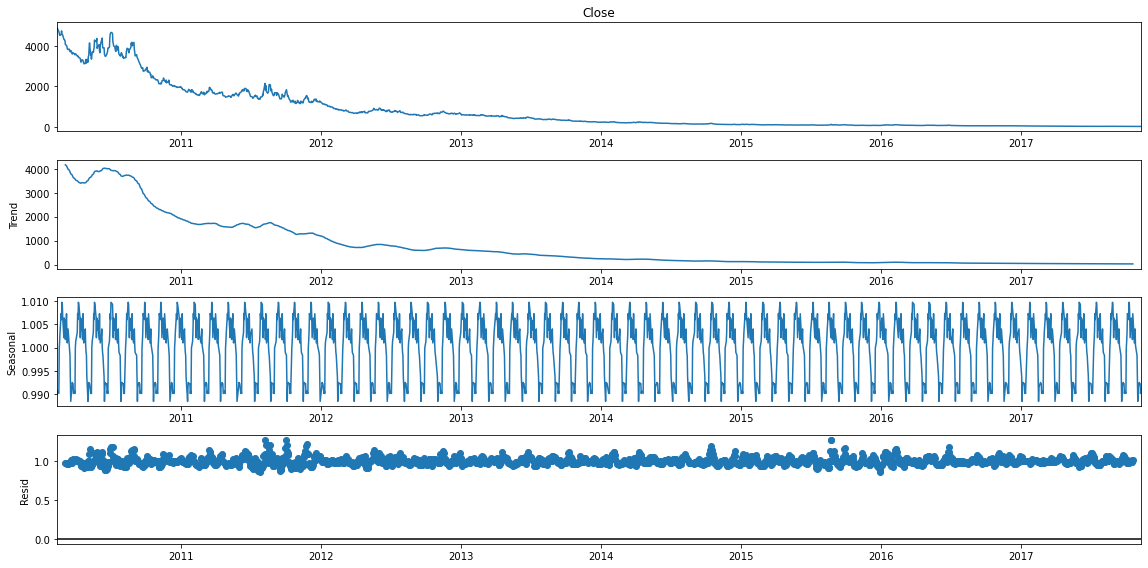

In [34]:
if (ch == 's' or ch == 'S'):
    seasonal_decomposition(stock_data[val],name)
elif (ch == 'e' or ch == 'E'):
    seasonal_decomposition(etf_data[val],name)

### Plotting test:train split

In [35]:
if (ch == 's' or ch == 'S'):
    train_data = splitter(stock_data[val])[0]
    val_data = splitter(stock_data[val])[1]
    test_data = splitter(stock_data[val])[2]
    lit_test = splitter(stock_data[val])[3]
elif (ch == 'e' or ch == 'E'):
    train_data = splitter(etf_data[val])[0]
    val_data = splitter(etf_data[val])[1]
    test_data = splitter(etf_data[val])[2]
    lit_test = splitter(etf_data[val])[3]

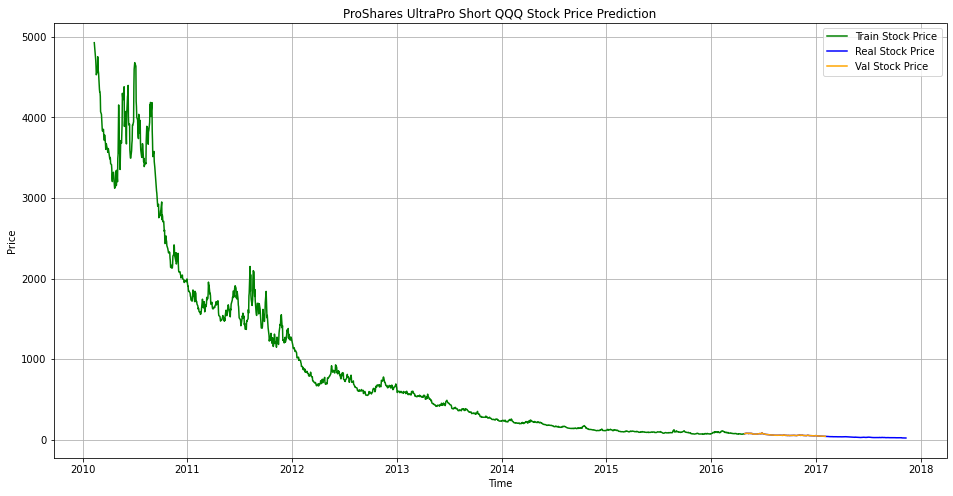

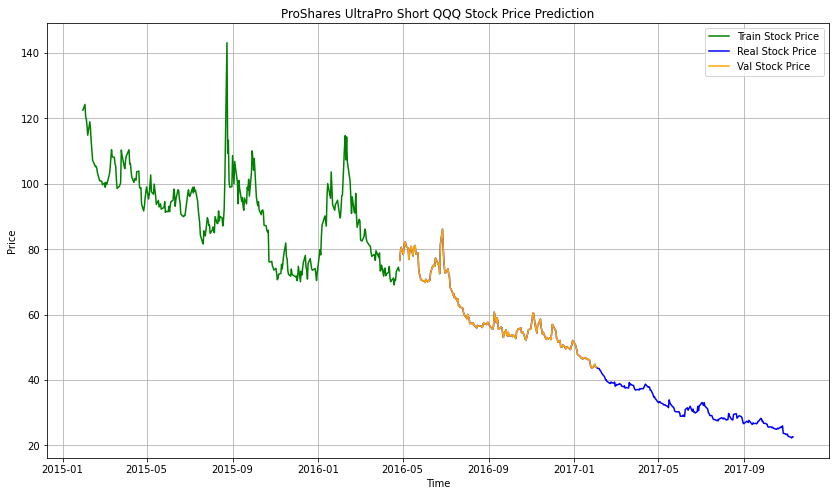

In [36]:
if (ch == 's' or ch == 'S'):
    in_plot(train_data, test_data, val_data, lit_test, stockout[val].Close,name)
elif (ch == 'e' or ch == 'E'):
    in_plot(train_data, test_data, val_data, lit_test, etfout[val].Close,name)

### Plotting Autocorrelation function and Partial Autocorrelation Function

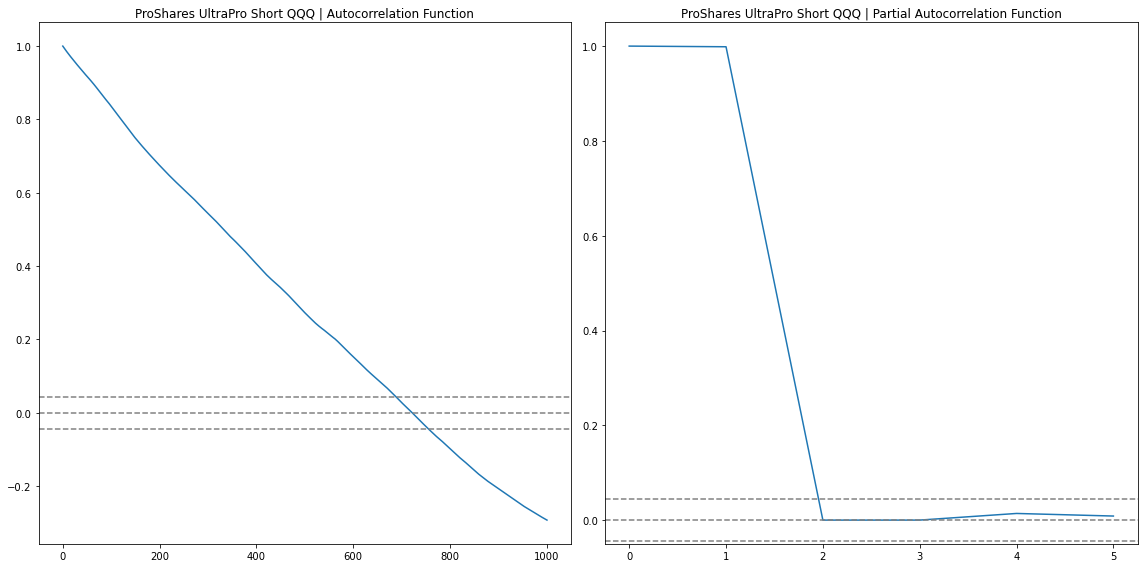

In [37]:
if (ch == 's' or ch == 'S'):
    plot_correlation(stock_data[val],name)
elif (ch == 'e' or ch == 'E'):
    plot_correlation(etf_data[val],name)

### Plotting Tranforms

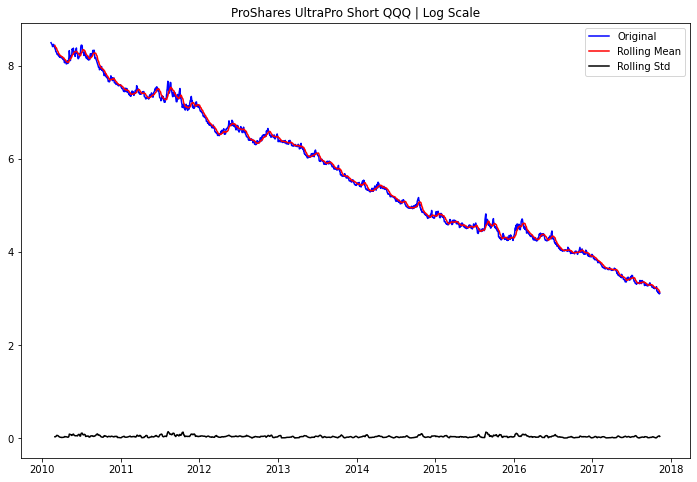

Results of Dickey-Fuller Test:
p-value = 0.8185. The series is likely non-stationary.
Test Statistic                   -0.801970
p-value                           0.818543
#Lags Used                        0.000000
Number of Observations Used    1951.000000
Critical Value (1%)              -3.433706
Critical Value (5%)              -2.863023
Critical Value (10%)             -2.567559
dtype: float64


In [38]:
if (ch == 's' or ch == 'S'):
    transformers(stock_data[val],4,name)
elif (ch == 'e' or ch == 'E'):
    transformers(etf_data[val],1,name)

### Plotting Final Predictions

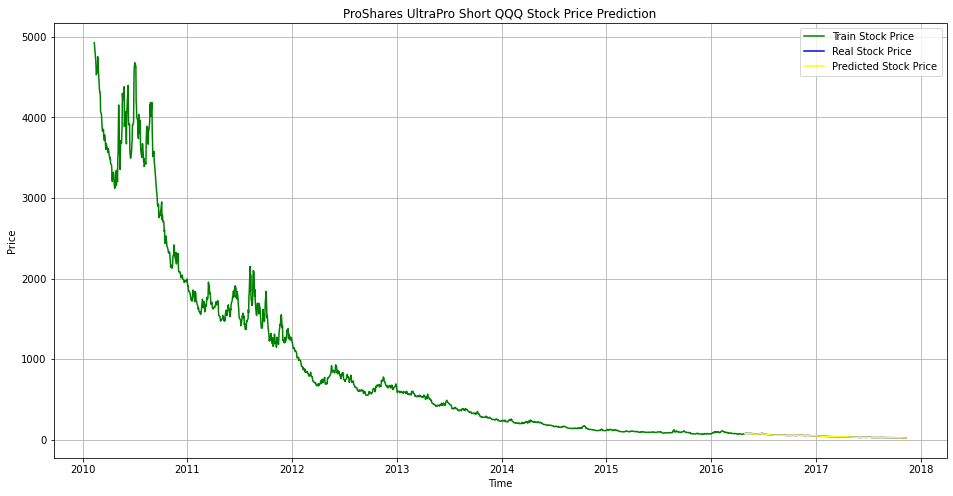

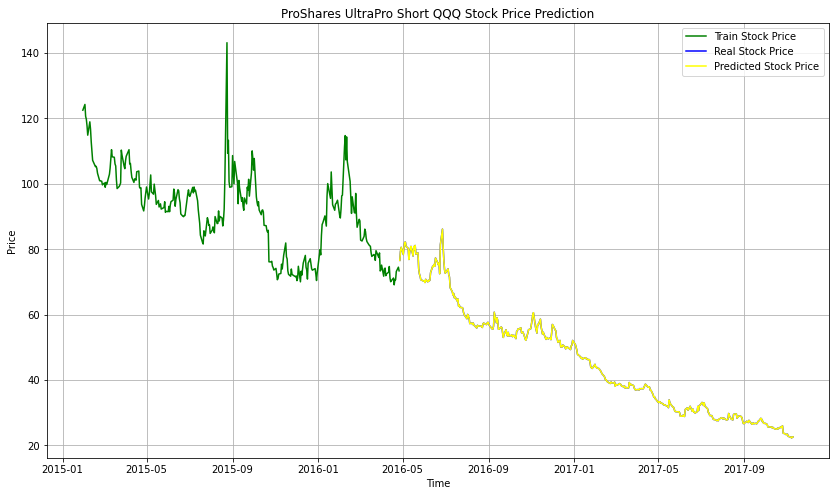

In [39]:
if (ch == 's' or ch == 'S'):
    fin_plot(train_data, test_data, val_data, lit_test, stockout[val].Close,name)
elif (ch == 'e' or ch == 'E'):
    fin_plot(train_data, test_data, val_data, lit_test, etfout[val].Close,name)

### Error in Prediction

In [40]:
if (ch == 's' or ch == 'S'):
    print(name)
    print('RMSE: '+str(get_rmse(stockout[val].Close,stockout[val].Predictions)))
    print('MAPE: '+str(get_mape(stockout[val].Close,stockout[val].Predictions)))
elif (ch == 'e' or ch == 'E'):
    print(name)
    print('RMSE: '+str(get_rmse(etfout[val].Close,etfout[val].Predictions)))
    print('MAPE: '+str(get_mape(etfout[val].Close,etfout[val].Predictions)))

ProShares UltraPro Short QQQ
RMSE: 1.293720066366241
MAPE: 1.6461766041186994


```
▪The End
```